# Product Discount Prediction

In [3]:
import pandas as pd
import numpy as np
from textblob import TextBlob
from sklearn.preprocessing import LabelEncoder
df = pd.read_csv("../data/processed/products.csv")

In [4]:
df.head()

,product_id,product_name,category,discounted_price,actual_price,discount_percentage,rating,rating_count,about_product,review_id,review_title,review_content,stock,creation_date,last_updated_date,status,supplier_id
0,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories|Accessories&Peripherals|...,399.0,1099.0,64.0,4.2,24269.0,High Compatibility : Compatible With iPhone 12...,"R3HXWT0LRP0NMF,R2AJM3LFTLZHFO,R6AQJGUP6P86,R1K...","Satisfied,Charging is really fast,Value for mo...",Looks durable Charging is fine tooNo complains...,3,2024-03-04,2024-08-14,active,860020/8/N/P/868
1,B098NS6PVG,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Computers&Accessories|Accessories&Peripherals|...,199.0,349.0,43.0,4.0,43994.0,"Compatible with all Type C enabled devices, be...","RGIQEG07R9HS2,R1SMWZQ86XIN8U,R2J3Y1WL29GWDE,RY...","A Good Braided Cable for Your Type C Device,Go...",I ordered this cable to connect my phone to An...,160,2025-05-19,2025-08-24,active,722656/5/F/C/788
2,B096MSW6CT,Sounce Fast Phone Charging Cable & Data Sync U...,Computers&Accessories|Accessories&Peripherals|...,199.0,1899.0,90.0,3.9,7928.0,【 Fast Charger& Data Sync】-With built-in safet...,"R3J3EQQ9TZI5ZJ,R3E7WBGK7ID0KV,RWU79XKQ6I1QF,R2...","Good speed for earlier versions,Good Product,W...","Not quite durable and sturdy,https://m.media-a...",61,2025-04-07,2025-12-04,active,896951/0/P/P/435
3,B08HDJ86NZ,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,Computers&Accessories|Accessories&Peripherals|...,329.0,699.0,53.0,4.2,94363.0,The boAt Deuce USB 300 2 in 1 cable is compati...,"R3EEUZKKK9J36I,R3HJVYCLYOY554,REDECAZ7AMPQC,R1...","Good product,Good one,Nice,Really nice product...","Good product,long wire,Charges good,Nice,I bou...",155,2021-03-05,2021-05-01,active,800531/2/P/N/305
4,B08CF3B7N1,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,Computers&Accessories|Accessories&Peripherals|...,154.0,399.0,61.0,4.2,16905.0,[CHARGE & SYNC FUNCTION]- This cable comes wit...,"R1BP4L2HH9TFUP,R16PVJEXKV6QZS,R2UPDB81N66T4P,R...","As good as original,Decent,Good one for second...","Bought this instead of original apple, does th...",15,2021-04-23,2021-08-29,active,337496/3/N/M/150


In [5]:
# quick check ( everything is processed )
print("=== SHAPE ===")
print(df.shape)
print("\n=== COLUMNS ===")
print(list(df.columns))
print("\n=== DTYPES ===")
print(df.dtypes)
print("\n=== MISSING VALUES PER COLUMN ===")
print(df.isna().sum())

=== SHAPE ===
(1465, 17)

=== COLUMNS ===
['product_id', 'product_name', 'category', 'discounted_price', 'actual_price', 'discount_percentage', 'rating', 'rating_count', 'about_product', 'review_id', 'review_title', 'review_content', 'stock', 'creation_date', 'last_updated_date', 'status', 'supplier_id']

=== DTYPES ===
product_id              object
product_name            object
category                object
discounted_price       float64
actual_price           float64
discount_percentage    float64
rating                 float64
rating_count           float64
about_product           object
review_id               object
review_title            object
review_content          object
stock                    int64
creation_date           object
last_updated_date       object
status                  object
supplier_id             object
dtype: object

=== MISSING VALUES PER COLUMN ===
product_id             0
product_name           0
category               0
discounted_price       0
ac

Data validation

In [6]:
expected = {"actual_price", "discounted_price", "discount_percentage"}
if expected.issubset(df.columns):
    # price-derived discount percentage
    with np.errstate(divide='ignore', invalid='ignore'):
        pct_from_prices = (df["actual_price"].astype(float) - df["discounted_price"].astype(float)) / df["actual_price"].astype(float)

    # Try interpreting discount_percentage as [0,1] vs [0,100]
    stated_0_1 = df["discount_percentage"].astype(float)
    stated_0_100 = df["discount_percentage"].astype(float) / 100.0

    diff_assuming_0_1 = (stated_0_1 - pct_from_prices).abs().mean(skipna=True)
    diff_assuming_0_100 = (stated_0_100 - pct_from_prices).abs().mean(skipna=True)

    print("\n=== DISCOUNT FIELD INTERPRETATION ===")
    print("Mean abs diff vs price-derived discount:")
    print(" - assuming discount_percentage in [0,1]:   ", round(float(diff_assuming_0_1), 6))
    print(" - assuming discount_percentage in [0,100]:", round(float(diff_assuming_0_100), 6))

    print("\n=== PRICE SANITY CHECKS ===")
    print("discounted_price > actual_price:", int((df["discounted_price"] > df["actual_price"]).sum()))
    print("non-positive actual/discounted price:", int(((df["actual_price"] <= 0) | (df["discounted_price"] <= 0)).sum()))
    print("missing in key fields (any of the three):",
          int(df[["actual_price","discounted_price","discount_percentage"]].isna().any(axis=1).sum()))
else:
    print("\n[WARNING] Missing one or more of:", expected)



=== DISCOUNT FIELD INTERPRETATION ===
Mean abs diff vs price-derived discount:
 - assuming discount_percentage in [0,1]:    47.21462
 - assuming discount_percentage in [0,100]: 0.002092

=== PRICE SANITY CHECKS ===
discounted_price > actual_price: 0
non-positive actual/discounted price: 0
missing in key fields (any of the three): 0


In [7]:
# Keep valid rows: discounted ≤ actual and both > 0
df = df[(df["actual_price"] > 0) &
        (df["discounted_price"] > 0) &
        (df["discounted_price"] <= df["actual_price"])]

In [8]:
df

,product_id,product_name,category,discounted_price,actual_price,discount_percentage,rating,rating_count,about_product,review_id,review_title,review_content,stock,creation_date,last_updated_date,status,supplier_id
0,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories|Accessories&Peripherals|...,399.0,1099.0,64.0,4.2,24269.0,High Compatibility : Compatible With iPhone 12...,"R3HXWT0LRP0NMF,R2AJM3LFTLZHFO,R6AQJGUP6P86,R1K...","Satisfied,Charging is really fast,Value for mo...",Looks durable Charging is fine tooNo complains...,3,2024-03-04,2024-08-14,active,860020/8/N/P/868
1,B098NS6PVG,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Computers&Accessories|Accessories&Peripherals|...,199.0,349.0,43.0,4.0,43994.0,"Compatible with all Type C enabled devices, be...","RGIQEG07R9HS2,R1SMWZQ86XIN8U,R2J3Y1WL29GWDE,RY...","A Good Braided Cable for Your Type C Device,Go...",I ordered this cable to connect my phone to An...,160,2025-05-19,2025-08-24,active,722656/5/F/C/788
2,B096MSW6CT,Sounce Fast Phone Charging Cable & Data Sync U...,Computers&Accessories|Accessories&Peripherals|...,199.0,1899.0,90.0,3.9,7928.0,【 Fast Charger& Data Sync】-With built-in safet...,"R3J3EQQ9TZI5ZJ,R3E7WBGK7ID0KV,RWU79XKQ6I1QF,R2...","Good speed for earlier versions,Good Product,W...","Not quite durable and sturdy,https://m.media-a...",61,2025-04-07,2025-12-04,active,896951/0/P/P/435
3,B08HDJ86NZ,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,Computers&Accessories|Accessories&Peripherals|...,329.0,699.0,53.0,4.2,94363.0,The boAt Deuce USB 300 2 in 1 cable is compati...,"R3EEUZKKK9J36I,R3HJVYCLYOY554,REDECAZ7AMPQC,R1...","Good product,Good one,Nice,Really nice product...","Good product,long wire,Charges good,Nice,I bou...",155,2021-03-05,2021-05-01,active,800531/2/P/N/305
4,B08CF3B7N1,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,Computers&Accessories|Accessories&Peripherals|...,154.0,399.0,61.0,4.2,16905.0,[CHARGE & SYNC FUNCTION]- This cable comes wit...,"R1BP4L2HH9TFUP,R16PVJEXKV6QZS,R2UPDB81N66T4P,R...","As good as original,Decent,Good one for second...","Bought this instead of original apple, does th...",15,2021-04-23,2021-08-29,active,337496/3/N/M/150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1460,B08L7J3T31,Noir Aqua - 5pcs PP Spun Filter + 1 Spanner | ...,Home&Kitchen|Kitchen&HomeAppliances|WaterPurif...,379.0,919.0,59.0,4.0,1090.0,SUPREME QUALITY 90 GRAM 3 LAYER THIK PP SPUN F...,"R3G3XFHPBFF0E8,R3C0BZCD32EIGW,R2EBVBCN9QPD9R,R...","Received the product without spanner,Excellent...","I received product without spanner,Excellent p...",33,2021-03-30,2021-08-10,active,434382/4/N/M/373
1461,B01M6453MB,Prestige Delight PRWO Electric Rice Cooker (1 ...,Home&Kitchen|Kitchen&HomeAppliances|SmallKitch...,2280.0,3045.0,25.0,4.1,4118.0,"230 Volts, 400 watts, 1 Year","R3DDL2UPKQ2CK9,R2SYYU1OATVIU5,R1VM993161IYRW,R...","ok,everything was good couldn't return bcoz I ...","ok,got everything as mentioned but the measuri...",1,2024-03-29,2024-05-31,active,501292/0/B/N/317
1462,B009P2LIL4,Bajaj Majesty RX10 2000 Watts Heat Convector R...,"Home&Kitchen|Heating,Cooling&AirQuality|RoomHe...",2219.0,3080.0,28.0,3.6,468.0,International design and styling|Two heat sett...,"R1TLRJVW4STY5I,R2O455KRN493R1,R3Q5MVGBRIAS2G,R...","very good,Work but front melt after 2 month,Go...","plastic but cool body ,u have to find sturdy s...",129,2022-11-25,2023-06-16,active,590296/7/F/P/722
1463,B00J5DYCCA,Havells Ventil Air DSP 230mm Exhaust Fan (Pist...,"Home&Kitchen|Heating,Cooling&AirQuality|Fans|E...",1399.0,1890.0,26.0,4.0,8031.0,Fan sweep area: 230 MM ; Noise level: (40 - 45...,"R39Q2Y79MM9SWK,R3079BG1NIH6MB,R29A31ZELTZNJM,R...","Fan Speed is slow,Good quality,Good product,go...",I have installed this in my kitchen working fi...,182,2021-11-18,2022-05-07,active,201550/0/A/P/323


In [9]:
# Using textBLob to get sentiment scores
def get_sentiment(text):
    """Return sentiment polarity score in [-1, 1]"""
    try:
        return TextBlob(str(text)).sentiment.polarity
    except:
        return 0

print("⏳ Computing sentiment polarity for review_content...")
df["review_sentiment"] = df["review_content"].apply(get_sentiment)
print("✅ Done. Example values:")
print(df[["review_content", "review_sentiment"]].head(5))

⏳ Computing sentiment polarity for review_content...
✅ Done. Example values:
                                      review_content  review_sentiment
0  Looks durable Charging is fine tooNo complains...          0.481944
1  I ordered this cable to connect my phone to An...          0.274318
2  Not quite durable and sturdy,https://m.media-a...          0.600000
3  Good product,long wire,Charges good,Nice,I bou...          0.240370
4  Bought this instead of original apple, does th...          0.262740


In [10]:
# dropping irrelevant / ID columns
cols_to_drop = [
    "product_id", "product_name", "about_product", "review_id",
    "creation_date", "last_updated_date", "supplier_id", "review_title","review_content"
]
df = df.drop(columns=cols_to_drop, errors="ignore")

In [11]:
# encoding categorical features into numerical ( 0, 1, 2)

# Category → numeric labels
le_category = LabelEncoder()
df["category_encoded"] = le_category.fit_transform(df["category"].astype(str))
# Status → numeric labels
le_status = LabelEncoder()
df["status_encoded"] = le_status.fit_transform(df["status"].astype(str))
# Drop old categorical text columns
df = df.drop(columns=["category", "status"])

In [12]:
keep_cols = [
    "discounted_price", "actual_price", "discount_percentage",
    "rating", "rating_count", "stock", "review_sentiment",
    "category_encoded", "status_encoded"
]
df = df[keep_cols]

In [13]:
df

,discounted_price,actual_price,discount_percentage,rating,rating_count,stock,review_sentiment,category_encoded,status_encoded
0,399.0,1099.0,64.0,4.2,24269.0,3,0.481944,10,0
1,199.0,349.0,43.0,4.0,43994.0,160,0.274318,10,0
2,199.0,1899.0,90.0,3.9,7928.0,61,0.600000,10,0
3,329.0,699.0,53.0,4.2,94363.0,155,0.240370,10,0
4,154.0,399.0,61.0,4.2,16905.0,15,0.262740,10,0
...,...,...,...,...,...,...,...,...,...
1460,379.0,919.0,59.0,4.0,1090.0,33,0.323810,192,0
1461,2280.0,3045.0,25.0,4.1,4118.0,1,0.142083,172,0
1462,2219.0,3080.0,28.0,3.6,468.0,129,0.212857,138,0
1463,1399.0,1890.0,26.0,4.0,8031.0,182,-0.170167,129,0


Feature selection & correlation analysis

In [14]:
# Defining the target feature
target = "discount_percentage"
features = [col for col in df.columns if col != target]

X = df[features]
y = df[target]

# Correlation analysis (numeric only)
print("=== Correlation with target (numeric only) ===")
corrs = df.corr(numeric_only=True)[target].sort_values(ascending=False)
print(corrs)

=== Correlation with target (numeric only) ===
discount_percentage    1.000000
review_sentiment       0.061679
rating_count           0.011097
stock                  0.005610
status_encoded        -0.006838
actual_price          -0.118098
rating                -0.155261
discounted_price      -0.242412
category_encoded      -0.314465
Name: discount_percentage, dtype: float64


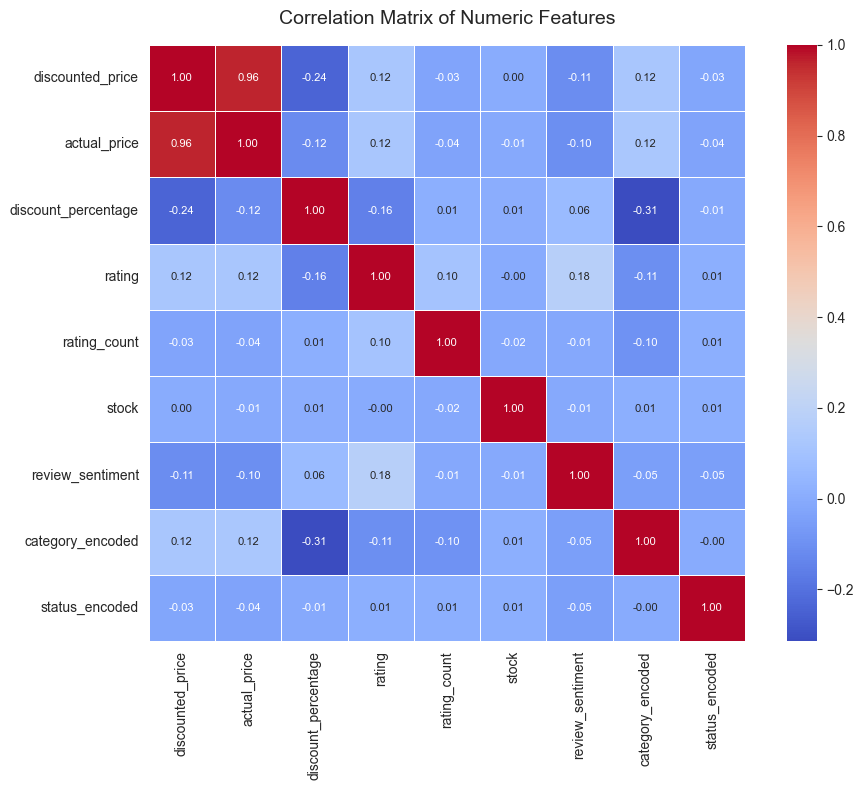

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
corr_matrix = df.corr(numeric_only=True)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar=True,
    square=True,
    linewidths=0.5,
    annot_kws={"size":8}
)
plt.title("Correlation Matrix of Numeric Features", fontsize=14, pad=15)
plt.tight_layout()
plt.show()

=== Top 10 Feature Importances ===
actual_price        0.438636
discounted_price    0.392363
category_encoded    0.091323
rating_count        0.032640
review_sentiment    0.017265
rating              0.012798
stock               0.012084
status_encoded      0.002892
dtype: float64


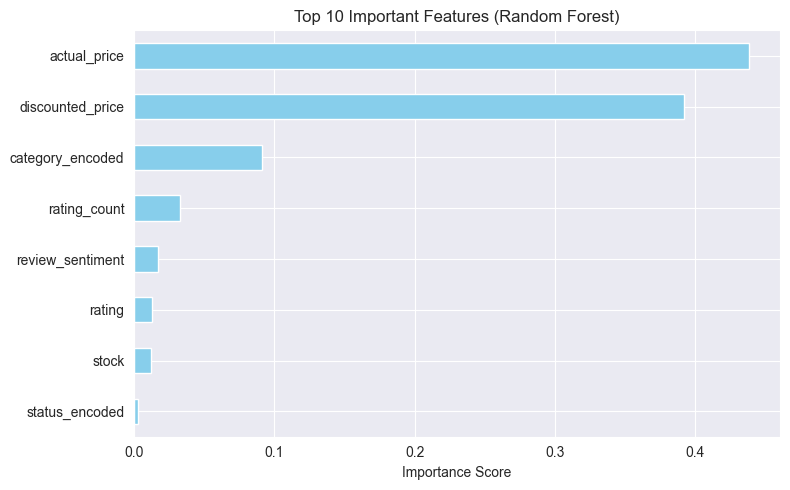

In [17]:
# Compute & plot feature importances

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# define target & features
target = "discount_percentage"
features = [col for col in df.columns if col != target]

X = df[features]
y = df[target]

# train/test split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# train a small random forest
rf = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# feature importances
feat_imp = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)

print("=== Top 10 Feature Importances ===")
print(feat_imp.head(10))

# plot
plt.figure(figsize=(8,5))
feat_imp.head(10).plot(kind='barh', color='skyblue')
plt.title("Top 10 Important Features (Random Forest)")
plt.xlabel("Importance Score")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [18]:
from sklearn.metrics import mean_absolute_error, r2_score

In [19]:
# only training models on the most important features
top_features = [
    "actual_price",
    "discounted_price",
    "category_encoded",
    "rating_count",
    "review_sentiment",
    "stock",
    "rating"
]

In [20]:
X = df[top_features]
y = df[target]

In [21]:
# splitting dataset into test and train
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Random Forest

In [22]:
#Train RandomForest model
model = RandomForestRegressor(
    n_estimators=400,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
print("⏳ Training final model...")
model.fit(X_train, y_train)

⏳ Training final model...


RandomForestRegressor(n_estimators=400, n_jobs=-1, random_state=42)

In [23]:
# Evaluate
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n📊 Evaluation Results:")
print("MAE:", round(mae, 2), "percentage points")
print("R² :", round(r2, 3))



📊 Evaluation Results:
MAE: 2.92 percentage points
R² : 0.94


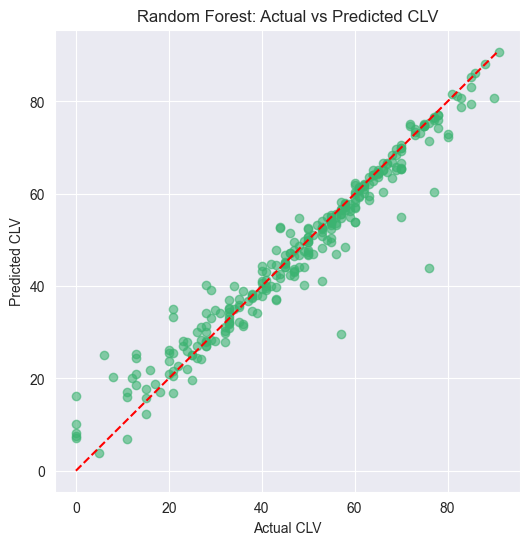

In [24]:
# compare prediction quality
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6, color='mediumseagreen')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual CLV")
plt.ylabel("Predicted CLV")
plt.title("Random Forest: Actual vs Predicted CLV")
plt.show()

# GradientBoosting

In [25]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    random_state=42
)
print("⏳ Training Gradient Boosting...")
gbr.fit(X_train, y_train)

⏳ Training Gradient Boosting...


GradientBoostingRegressor(learning_rate=0.05, max_depth=5, n_estimators=500,
                          random_state=42, subsample=0.8)

In [26]:
# evaluate
y_pred = gbr.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n📊 Gradient Boosting Results:")
print("MAE:", round(mae, 2))
print("R² :", round(r2, 3))


📊 Gradient Boosting Results:
MAE: 2.28
R² : 0.963


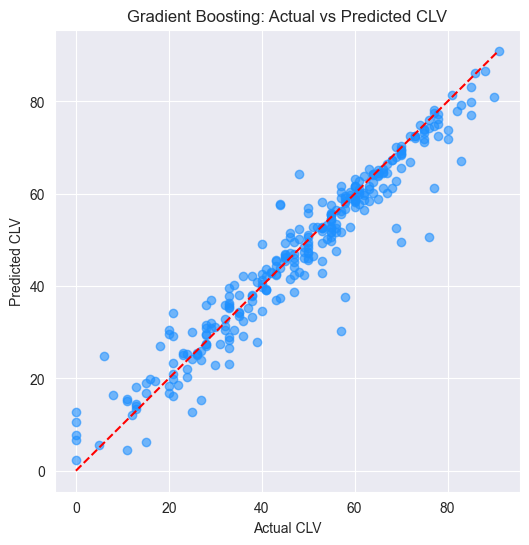

In [32]:
# compare prediction quality
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6, color='dodgerblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual CLV")
plt.ylabel("Predicted CLV")
plt.title("Gradient Boosting: Actual vs Predicted CLV")
plt.show()

# XGBResgressor

In [28]:
from xgboost import XGBRegressor
xgb_model = XGBRegressor(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1
)

print("⏳ Training XGBoost...")
xgb_model.fit(X_train, y_train)


⏳ Training XGBoost...


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=600, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [29]:
y_pred = xgb_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n📊 XGBoost Results:")
print("MAE:", round(mae, 2))
print("R² :", round(r2, 3))


📊 XGBoost Results:
MAE: 3.52
R² : 0.926


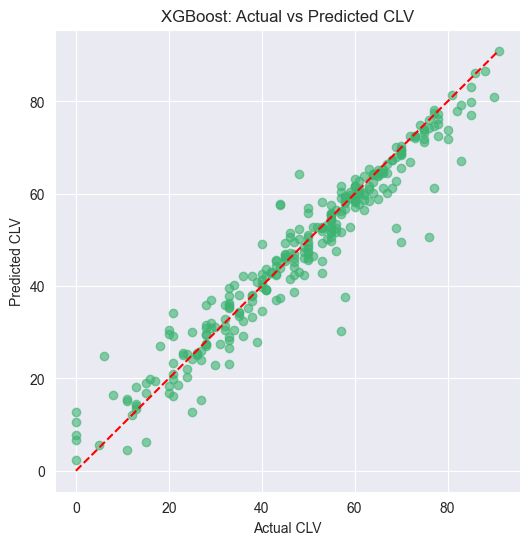

In [31]:
# compare prediction quality
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6, color='mediumseagreen')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual CLV")
plt.ylabel("Predicted CLV")
plt.title("XGBoost: Actual vs Predicted CLV")
plt.show()

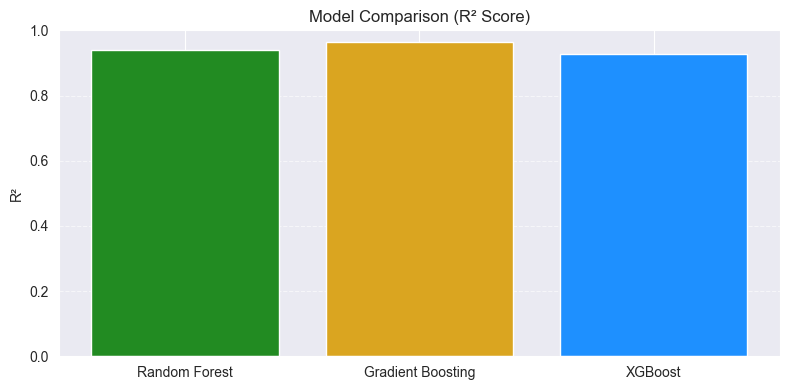

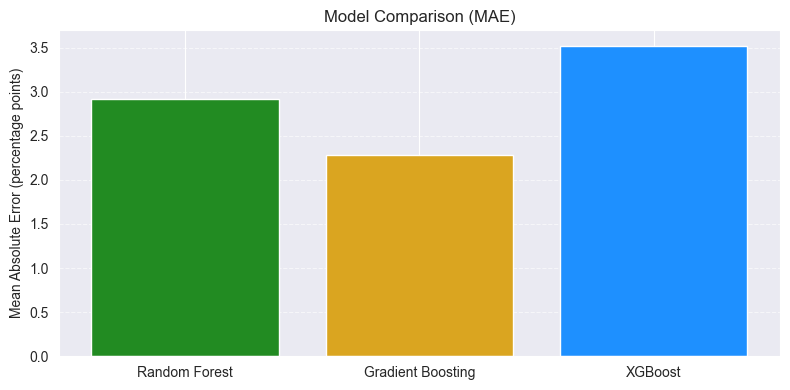

In [24]:
# Compare R² and MAE for the three models

import matplotlib.pyplot as plt
import pandas as pd

# replace with your real results
# (edit with the numbers you obtained)
results = pd.DataFrame({
    "Model": ["Random Forest", "Gradient Boosting", "XGBoost"],
    "R2": [0.94, 0.963, 0.926],   # <--- fill with your actual R² scores
    "MAE": [2.92,  2.28,  3.52]          # <--- fill with your actual MAE values
})

# --- R² plot ---
plt.figure(figsize=(8,4))
plt.bar(results["Model"], results["R2"], color=["forestgreen","goldenrod","dodgerblue"])
plt.title("Model Comparison (R² Score)")
plt.ylabel("R²")
plt.ylim(0,1)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# --- MAE plot ---
plt.figure(figsize=(8,4))
plt.bar(results["Model"], results["MAE"], color=["forestgreen","goldenrod","dodgerblue"])
plt.title("Model Comparison (MAE)")
plt.ylabel("Mean Absolute Error (percentage points)")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


# Gradient Boosting gives the lowest MAE and highest R² → it predicts discount % with the highest precision and consistency.

In [25]:
import joblib

# Save model to file
joblib.dump(gbr, "../model/gradient_boosting_model.pkl")

print("✅ Model saved as gradient_boosting_model.pkl")


✅ Model saved as gradient_boosting_model.pkl
